In [54]:
import time


import pandas as pd
import numpy as np
import os
from brick import Brick
from astropy.io import fits
import healpy as hp
import matplotlib.pyplot as plt


### Working on extracting the first systematic from the dataset -  stellar Density

Data use: We create a catalog of stars from DECaLS by selecting objects lying in the stellar locus (using the color cut 17 < r < 18) with PSF morphology.

Information on a per brick basis

In [55]:
hdulistBricksSouthSummary = fits.open('../bricks_data/survey-bricks-dr9-south.fits')
data_south = hdulistBricksSouthSummary[1].data
brickname_south = data_south.field('brickname')
brickid_south = data_south.field('brickid')
south_survey_is_south = data_south.field('survey_primary')

hdulistBricksNorthSummary = fits.open('../bricks_data/survey-bricks-dr9-north.fits')
data_north = hdulistBricksNorthSummary[1].data
brickname_north = data_north.field('brickname')
brickid_north = data_north.field('brickid')
survey_north = data_north.field('survey_primary')
north_survey_is_south = np.invert(survey_north)

In [56]:
print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

bricknames_south_sample.pop()
def get_stellar_objects(self):

        is_PSF =  (self.type == 'PSF') & (self.flux_r > 17) & (self.flux_r < 18)
        return is_PSF

df = pd.DataFrame(columns=['RA', 'DEC', 'GMAG', 'RMAG', 'ZMAG', 'GMR', 'RMZ'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data
    ra = data.field('ra')
    dec = data.field('dec')
    brick = Brick(data)
    brick.initialise_brick_for_stellar_density()

    stars = get_stellar_objects(brick)


    mag_g = 22.5-2.5*np.log10(brick.flux_g.clip(1e-7))
    mag_r = 22.5-2.5*np.log10(brick.flux_r.clip(1e-7))
    mag_z = 22.5-2.5*np.log10(brick.flux_z.clip(1e-7))

    gmr = mag_g-mag_r
    rmz = mag_r-mag_z

    stacked_array = np.stack(( ra, dec, mag_g, mag_r, mag_z, gmr, rmz), axis=1)
    stacked_array = stacked_array[np.where(stars == True)]

    support_df = pd.DataFrame(stacked_array, columns=['RA', 'DEC', 'GMAG', 'RMAG', 'ZMAG', 'GMR', 'RMZ'])
    df = df.append(support_df)

    if no % 50 == 0:
        print(no)
print(df.head())
df.describe()
df = df.drop_duplicates()
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)



=============================== Classification Stellar Density... ==================================

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
           RA        DEC       GMAG       RMAG       ZMAG       GMR       RMZ
0  244.271632  25.664881  20.708857  19.396591  18.526617  1.312265  0.869974
1  244.439524  25.798856  19.785728  19.375338  19.232027  0.410391  0.143311
2  244.485410  25.680604  20.109619  19.384590  19.019024  0.725029  0.365566
3  244.521375  25.848226  20.256311  19.390028  18.925837  0.866283  0.464191
0  332.670454  20.080288  20.428534  19.376266  18.823677  1.052267  0.552589


In [59]:
df.describe()

,RA,DEC,GMAG,RMAG,ZMAG,GMR,RMZ
count,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000,4739.000000
mean,200.281833,-2.427105,20.637807,19.392948,18.867243,1.244860,0.525705
std,110.909800,26.907110,2.049139,0.017703,2.510559,2.049718,2.510268
min,0.094336,-67.840435,18.542273,19.361879,16.483784,-0.831503,-20.638035
25%,94.477568,-16.398013,20.011427,19.377566,18.128405,0.616101,0.273172
50%,226.274154,4.724341,20.593214,19.392826,18.747299,1.198912,0.649530
75%,309.468005,18.494807,20.830150,19.408355,19.120863,1.435865,1.266005
max,359.941291,35.373616,40.000000,19.423870,40.000000,20.637215,2.899254


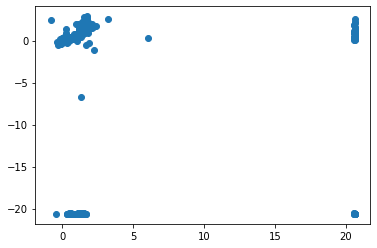

In [67]:

plt.scatter(df['GMR'], df['RMZ'])

In [ ]:
for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south_test/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data
    ra = data.field('ra')
    dec = data.field('dec')
    brick = Brick(data)
    brick.initialise_brick_for_stellar_density()
    fluxr = brick.get_stellar_objects()
    print(len(fluxr))
    plt.hist(fluxr, range=(0,30))
    plt.show()
    

    if no == 0:
        break

In [24]:
print("Wrong Cell")
exit()

print()
print("=============================== Classification Stellar Density... ==================================")
print()

start = time.time()

bricknames_south_sample = []

for filename in os.listdir('/Volumes/Astrostick/bricks_data/south/'):
    brickn = filename.replace("tractor-", "")
    brickn = brickn.replace(".fits", "")
    bricknames_south_sample.append(brickn)

#bricknames_south_sample.pop()
df = pd.DataFrame(columns=['RA', 'DEC'])

for no, brickname in enumerate(bricknames_south_sample):
    hdulistSingleBrick = fits.open(f'/Volumes/Astrostick/bricks_data/south/tractor-{brickname}.fits')
    data = hdulistSingleBrick[1].data

    brick = Brick(data)
    ra = data.field('ra')
    dec = data.field('dec')

    brick.initialise_brick_for_stellar_density()

    # Extracting Positions, and Object IDs

    stellar_density = brick.get_stellar_objects()

    # Process array
    stacked_array = np.stack(( ra, dec, stellar_density), axis=1)
    support_df = pd.DataFrame(stacked_array, columns=['RA', 'DEC', 'Target_type'])
    support_df.drop(support_df[support_df.Target_type == 0].index, inplace=True)
    support_df.drop(columns='Target_type')
    df = df.append(support_df)

print()
print("=============================== Classification Stellar Completed ==================================")
print()
df = df[df['Target_type'] > 0]
df.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)
print(df.shape)
print(df.head())

print("Time taken for ", len(bricknames_south_sample), " bricks: ", time.time() - start)


=============================== Classification Stellar Density... ==================================



ValueError: all input arrays must have the same shape

In [ ]:
df = pd.read_csv('../bricks_data/galaxy_catalogue_stellar.csv')

duplicates_removed = df.drop_duplicates()

duplicates_removed.to_csv('../bricks_data/galaxy_catalogue_stellar.csv', index=False)


# Setting NSIDE values
NSIDE = 256
NPIX = hp.nside2npix(NSIDE)
print(
    "Approximate resolution at NSIDE {} is {:.2} deg".format(
        NSIDE, hp.nside2resol(NSIDE, arcmin=True) / 60
    )
)

In [ ]:
def raDec2thetaPhi(ra, dec):
    return (0.5 * np.pi - np.deg2rad(dec)), (np.deg2rad(ra))

In [ ]:
ra = df["RA"].to_numpy(copy=True)
dec = df["DEC"].to_numpy(copy=True)

theta, phi = raDec2thetaPhi(ra, dec)

print("Number of stellar objects in Sample:", len(ra))

m = np.zeros(NPIX)
pixel_indices = hp.ang2pix(NSIDE, theta,phi)

# Finding out unique indices and how often they appear --> shows the density of Stars in this pixel
(unique, counts) = np.unique(pixel_indices, return_counts=True)

mean = counts.mean()
print("Mean stellar objects per Pixel:", mean)
# Calculating Densities for every block
density = (counts / mean) - 1

m[unique] = density
hp.mollview(m, title="Stellar Density", norm="hist",cmap="jet")
hp.graticule()